# Thorpe Scales

<div class="alert alert-info">

This section is available as a jupyter notebook in the `docs/` directory or at https://github.com/modscripps/mixsea/tree/main/docs.

</div>

Here we'll examine some of the different parameter options used for estimating the turbulent dissipation rate, $\epsilon$, from Thorpe scales. The method was first published by Stephen Thorpe– see <cite data-cite="Thorpe1977">Thorpe (1977)</cite>. 

<div class="alert alert-info">

**Basic idea**

Thorpe's method for estimating dissipation relies on the Ozmidov scale
    
\begin{equation}
L_{O}=\alpha \epsilon^{1/2} N^{-3/2},
\end{equation}
    
defined by dimensional analysis as the scale at which stratification begins to affect turbulence, where $\alpha=\mathcal{O}(1)$ is a proportionality constant and $N$ is a measure of the background stratification (we will see later the importance of its definition).
    
Thorpe's insight was to identify the Ozmidov scale with the scale $L_{T}$ (now named after him) of the largest vertical overturns (gravitational instability) observed in a density profile. He proposed sorting the unstable profile to produce a stable one, keeping track of individual water parcels vertical displacements to use their root mean square displacement $d(z)$ as a proxy for the overturn scale
\begin{equation}
L_{T} = \sqrt{\overline{d^{2}}}.
\end{equation}

Setting $L_{O} = L_{T}$ and inverting for $\epsilon$ gives
\begin{equation}
\boxed{\epsilon = C_{0} L_{T}^{2} N^{3},}
\end{equation}
    
where we identify $C_{0} = \alpha^{-2}$ as an $\mathcal{O}(1)$ free parameter, perhaps tuned based on microstructure measurements of $\epsilon$.
    
***Warning:** The Thorpe scale method is an **event-based** turbulence parameterization, so one must be wary of spatial and temporal intermittency when interpreting results.*
</div>

Thus, the Thorpe scale method in practice can be separated three steps: 1) finding the overturns, 2) determining their Thorpe scales by sorting, and 3) determining the background stratification.

## Example

First, we load modules and example data.

In [1]:
import mixsea as mx
import numpy as np
import matplotlib.pyplot as plt

ctd = mx.helpers.read_ctd_testfile()

Our example data contain some NaN values, as is common with observational datasets. Below we isolate the good data by removing NaNs.

In [2]:
notnan = np.isfinite(ctd["depth"]) & np.isfinite(ctd["t"]) & np.isfinite(ctd["SP"])

depth = ctd["depth"][notnan]
t = ctd["t"][notnan]
SP = ctd["SP"][notnan]
lon = ctd["lon"][0]
lat = ctd["lat"][0]

### A detailed look at the output and diagnostics

Now we run the Thorpe scale function on the good test data, selecting input parameters that are reasonable for the deep ocean. 

In [3]:
dnoise = 5e-4  # Noise parameter
alpha = 0.95  # Coefficient relating the Thorpe and Ozmidov scales.
# Background value of epsilon applied where no overturns are detected.
background_eps = np.nan
# Do not use the intermediate profile method
use_ip = False
# Critical value of the overturn ratio
Roc = 0.3

# Calculate Thorpe scales and diagnostics.
eps, N2, diag = mx.overturn.eps_overturn(
    depth,
    t,
    SP,
    lon,
    lat,
    dnoise=dnoise,
    alpha=alpha,
    Roc=Roc,
    background_eps=background_eps,
    use_ip=use_ip,
    return_diagnostics=True,
)

The standard output `eps` and `N2` (buoyancy frequency squared) have been quality controlled. The type and strictness of quality control can be set using arguments to `eps_overturn` (see the function docstring for details) In addition, numerous diagnostic variables are output in the dictionary `diag`. The diagnostic dictionary contains output from pre-quality control, as well as, flags which indicate the quality control state and miscellanous other variables that might be useful. 

In [4]:
for key in diag:
    print(key)

eps
N2
Lt
thorpe_disp
sidx
dens
dens_sorted
Ro
SA_sorted
CT_sorted
noise_flag
N2_flag
ends_flag
Ro_flag


Some of the diagnostics are as follows:

* `eps`: the dissipation rate estimated before applying quality control flags.
* `N2`: the buoyancy frequency squared estimated before applying quality control flags.
* `Lt`: the Thorpe scale.
* `thorpe_disp`: the Thorpe displacements.
* `sidx`: the density-sorted indices of the original profile
* `dens`: potential density (this may appear 'steppy' due to the use of different reference pressures at for different pressure ranges).
* `dens_sorted`: sorted potential density.
* `dens_ip`: density from the intermediate profile method. (Does not appear in the list above because the intermediate profile method was not used)
* `CT_ip`: conservative temperature from the intermediate profile method. (Does not appear in the list above because intermediate profile method was not used)
* `Ro`: the overturn ratio.
* `CT_sorted`: sorted conservative temperature.
* `SA_sorted`: sorted absolute salinity.

Some of the quality control flags:

* `noise_flag`: if density/CT difference from the top to bottom of the overturn is less than the noise parameter, this flag will be True.
* `N2_flag`: if buoyancy frequency is negative, this flag will be True.
* `ends_flag`: if an overturn contains the first or last point in the data, this flag will be True.
* `Ro_flag`: if the overturn ratio is less than the critical value, this flag will be True.

If we zoom into a segment, it is easier to understand what these diagnostics mean.

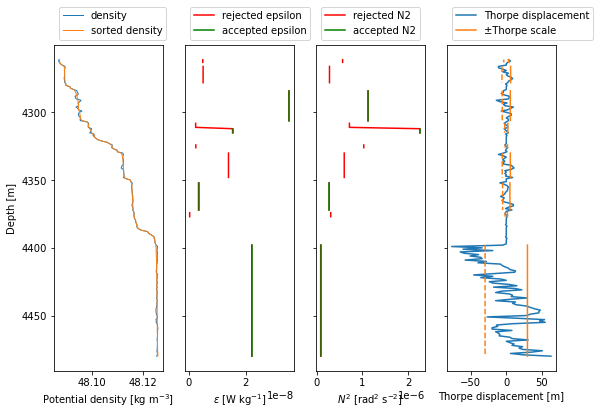

In [5]:
# Plot only in the depth range:
cut = (depth > 4260) & (depth < 4500)
zc = depth[cut]

# finding unsorting indices for intuitive Thorpe displacements
#idx_unsorted = np.argsort(idx_sorted)

#axs[1].plot(thorpe_displacement[idx_unsorted][inoverturn_unsorted], z[inoverturn_unsorted])

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(9, 6))
axs[0].plot(diag["dens"][cut]-1000, zc, label="density", lw=1.)
axs[0].plot(diag["dens_sorted"][cut]-1000, zc, label="sorted density", lw=1.)
axs[1].plot(diag["eps"][cut], zc, label="rejected epsilon", color="r")
axs[1].plot(eps[cut], zc, label="accepted epsilon", color="g")
axs[2].plot(diag["N2"][cut], zc, label="rejected N2", color="r")
axs[2].plot(N2[cut], zc, label="accepted N2", color="g")
axs[3].plot(diag["thorpe_disp"][cut], zc, label="Thorpe displacement")
axs[3].plot(diag["Lt"][cut], zc, label="±Thorpe scale")
axs[3].plot(-diag["Lt"][cut], zc, "C1--")
axs[0].invert_yaxis()
axs[0].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[1].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[2].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[3].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[0].set_ylabel("Depth [m]")
axs[0].set_xlabel("Potential density [kg m$^{-3}$]")
axs[1].set_xlabel(r"$\epsilon$ [W kg$^{-1}$]")
axs[2].set_xlabel(r"$N^2$ [rad$^2$ s$^{-2}$]")
axs[3].set_xlabel("Thorpe displacement [m]")

fig.align_labels()

Starting from the left, we have potential density and sorted potential density. Overturning patches should correspond to regions where the potential density is different from the sorted potential density. Next is the dissipation rate, $\epsilon$, plotted in green are the values that have passed quality control and in red those that were rejected by some criteria. The plot looks a bit odd because there are jumps in $\epsilon$. This is caused by small overturns adjacent to large overturns. Ultimately, a lot of small overturns will be rejected by quality control. Third from the left is buoyancy frequency, which can be calculated in a number of different ways. We will explore this in more detail later. Last is the Thorpe displacements and Thorpe length scale. Large negative values atop large positive values represent large overturns; whether this leads to large dissipation depends on the stratification.

The state (true/false) of some of the quality control flags is plotted below for the same segment of data.

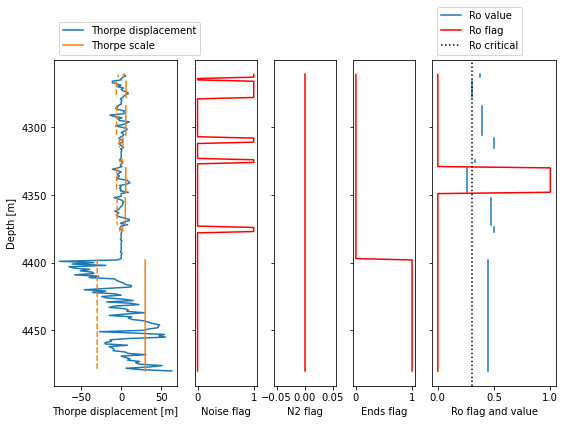

In [6]:
fig, axs = plt.subplots(
    1, 5, sharey=True, figsize=(9, 6), gridspec_kw={"width_ratios": [2, 1, 1, 1, 2]}
)
axs[0].plot(diag["thorpe_disp"][cut], zc, label="Thorpe displacement")
axs[0].plot(diag["Lt"][cut], zc, label="Thorpe scale")
axs[0].plot(-diag["Lt"][cut], zc, "C1--")
axs[1].plot(diag["noise_flag"][cut], zc, color="r")
axs[2].plot(diag["N2_flag"][cut], zc, color="r")
axs[3].plot(diag["ends_flag"][cut], zc, color="r")
axs[4].plot(diag["Ro"][cut], zc, label="Ro value")
axs[4].plot(diag["Ro_flag"][cut], zc, color="r", label="Ro flag")
axs[4].axvline(Roc, color="k", ls=":", label="Ro critical")
axs[0].invert_yaxis()
axs[0].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[4].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[0].set_ylabel("Depth [m]")
axs[0].set_xlabel("Thorpe displacement [m]")
axs[1].set_xlabel("Noise flag")
axs[2].set_xlabel("N2 flag")
axs[3].set_xlabel("Ends flag")
axs[4].set_xlabel("Ro flag and value")

fig.align_labels()

The noise flag is raised (true) where the density difference (top to bottom) of the overturning region is smaller than the noise parameter. The N2 flag has not been raised anywhere, indicating there are no regions of negative buoyancy frequency. The ends flag is raised for the last overturn since it contains the end point of the data. However, it is just a warning flag and not used to quality control the output. The Ro flag is raised where the overturn ratio is less than the critical value <cite data-cite="Gargett2008">Gargett and Garner (2008)</cite>. Note that for this demonstration we have set the critical overturn ratio a bit higher than would be normal.  

### The intermediate profile method

The intermediate profile method attempts to reduce the influence of random noise when estimating overturns. For technical details, see <cite data-cite="Ferron1998">Ferron et al. (1998)</cite> and <cite data-cite="Gargett2008">Gargett and Garner (2008)</cite>.

What does the method do? Here we construct three intermediate profiles from a segment of temperature data. 

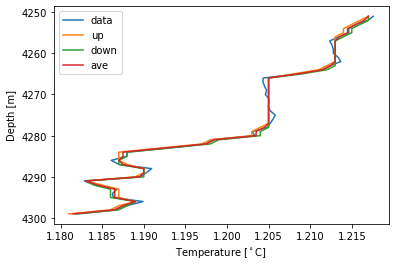

In [7]:
acc = 1e-3
hinge = 0

# Restrict ourselves to:
cut = (depth < 4300) & (depth > 4250)

tup = mx.overturn.intermediate_profile(t[cut], acc, hinge, 'up')
tdo = mx.overturn.intermediate_profile(t[cut], acc, hinge, 'down')
tav = mx.overturn.intermediate_profile(t[cut], acc, hinge, 'ave')

fig, ax = plt.subplots(1, 1)
ax.invert_yaxis()
ax.plot(t[cut], depth[cut], label='data')
ax.plot(tup, depth[cut], label='up')
ax.plot(tdo, depth[cut], label='down')
ax.plot(tav, depth[cut], label='ave')
ax.legend()
ax.set_xlabel('Temperature [$^\circ$C]')
ax.set_ylabel('Depth [m]');

The method creates a new profile that moves in increments of the argument `acc`, which is a measure of the accuracy of the observations. A region that looks unstable in the data (such as the cold water over light in the region around 4270 m) might be smoothed out in the intermediate profile because the fluctuations are less than the accuracy. The method can be applied top down (`down`), bottom up (`up`) or the average of up and down (`ave`). 

Now we investigate what the method does to estimates of $\epsilon$. 

In [8]:
dnoise = 5e-4
alpha = 0.95
# Use the intermediate profile method
use_ip = True

eps, N2, diag = mx.overturn.eps_overturn(
    depth,
    t,
    SP,
    lon,
    lat,
    dnoise=dnoise,
    alpha=alpha,
    use_ip=use_ip,
    return_diagnostics=True,
)

Plot the same depth range as the case that did not use the method.

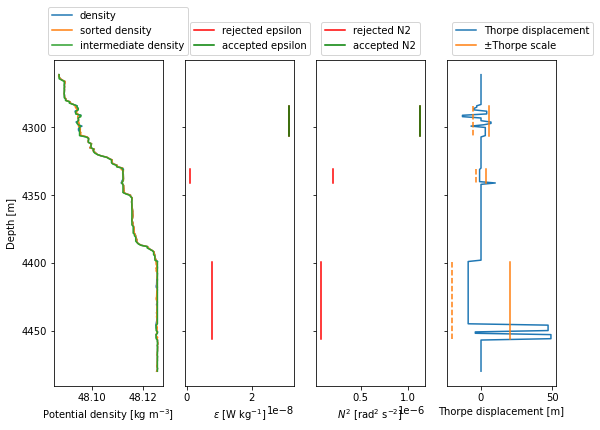

In [9]:
cut = (depth > 4260) & (depth < 4500)
zc = depth[cut]

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(9, 6))
axs[0].plot(diag["dens"][cut]-1000, zc, label="density")
axs[0].plot(diag["dens_sorted"][cut]-1000, zc, label="sorted density")
axs[0].plot(diag["dens_ip"][cut]-1000, zc, label="intermediate density")
axs[1].plot(diag["eps"][cut], zc, label="rejected epsilon", color="r")
axs[1].plot(eps[cut], zc, label="accepted epsilon", color="g")
axs[2].plot(diag["N2"][cut], zc, label="rejected N2", color="r")
axs[2].plot(N2[cut], zc, label="accepted N2", color="g")
axs[3].plot(diag["thorpe_disp"][cut], zc, label="Thorpe displacement")
axs[3].plot(diag["Lt"][cut], zc, label="±Thorpe scale")
axs[3].plot(-diag["Lt"][cut], zc, "C1--")
axs[0].invert_yaxis()
axs[0].legend(loc="lower left", bbox_to_anchor=(-0.1, 1))
axs[1].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[2].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[3].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[0].set_ylabel("Depth [m]")
axs[0].set_xlabel("Potential density [kg m$^{-3}$]")
axs[1].set_xlabel(r"$\epsilon$ [W kg$^{-1}$]")
axs[2].set_xlabel(r"$N^2$ [rad$^2$ s$^{-2}$]")
axs[3].set_xlabel("Thorpe displacement [m]")

fig.align_labels()

Now we're using the intermediate profile method, the results have changed dramatically. Overturns are diagnosed from the intermediate profile of density, which is different to the actual density. The overturning patches may be of different sizes to those estimated without the intermediate profile. Sorting the intermediate profile results in strange looking Thorpe displacements, because the sorting algorithm struggles when many data points have an identical value. There is an argument to be made the method should not be applied to data that has already been bin averaged (as ours has) and the method may work better on raw CTD data that is more noisy.

Because the intermediate profile method fundamentally changes many aspects of the Thorpe scale method, including the size of detected overturns and the Thorpe displacements, it is not straightforward or necessarily meaningful to raise a flag for rejected overturns. Consequently, most flags are disabled when using the method and so are not shown.

### Compare methods of estimating $N^2$

There are a few different options for calculating buoyancy frequency:

In [10]:
use_ip = False

# Choose buoyancy frequency method
N2_method = "teosp1"
eps_teosp1, N2_teosp1 = mx.overturn.eps_overturn(
    depth, t, SP, lon, lat, use_ip=use_ip, N2_method=N2_method,
)

N2_method = "teos"
eps_teos, N2_teos = mx.overturn.eps_overturn(
    depth, t, SP, lon, lat, dnoise, use_ip=use_ip, N2_method=N2_method,
)

N2_method = "bulk"
eps_bulk, N2_bulk = mx.overturn.eps_overturn(
    depth, t, SP, lon, lat, use_ip=use_ip, N2_method=N2_method,
)

N2_method = "endpt"
eps_endpt, N2_endpt = mx.overturn.eps_overturn(
    depth, t, SP, lon, lat, use_ip=use_ip, N2_method=N2_method,
)

A brief explanation of the methods:

* `teos`: This method estimates $N^2$ from the thermodynamic equation of state 2010 (TEOS), using the tempurature and salinity at the first and last point in the overturn.
* `toesp1`: This method is the same as above except it uses the temperature and salinity from the points immediately above and below the overturn (p1 meaning plus 1).
* `bulk`: This method comes from <cite data-cite="Smyth2001">Smyth et al. (2001)</cite> and has the advantage of being insensitive to errors in determining the patch size. Buoyancy frequency is proportional to the root mean square density anomaly of an overturn, divided by the Thorpe scale.
* `endpt`: This simple method estimates buoyancy frequency from the potential density gradient across each overturn.

More methods may be added in future versions of `mixsea`.

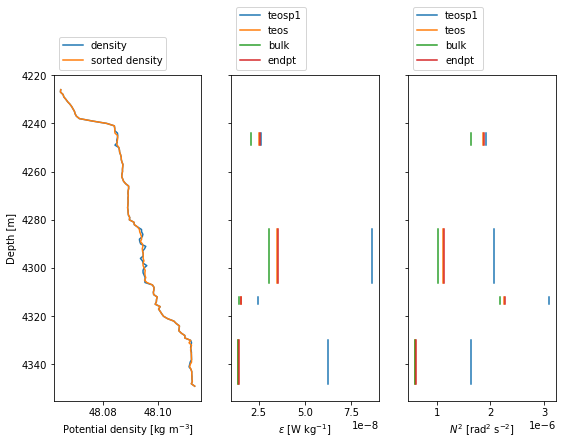

In [11]:
# Plot only in the depth range:
cut = (depth > 4225) & (depth < 4350)
zc = depth[cut]

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(9, 6))
axs[0].plot(diag["dens"][cut]-1000, zc, label="density")
axs[0].plot(diag["dens_sorted"][cut]-1000, zc, label="sorted density")
axs[1].plot(eps_teosp1[cut], zc, label="teosp1")
axs[1].plot(eps_teos[cut], zc, label="teos")
axs[1].plot(eps_bulk[cut], zc, label="bulk")
axs[1].plot(eps_endpt[cut], zc, label="endpt")
axs[2].plot(N2_teosp1[cut], zc, label="teosp1")
axs[2].plot(N2_teos[cut], zc, label="teos")
axs[2].plot(N2_bulk[cut], zc, label="bulk")
axs[2].plot(N2_endpt[cut], zc, label="endpt")
axs[0].invert_yaxis()
axs[0].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[1].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[2].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[0].set_ylabel("Depth [m]")
axs[0].set_xlabel("Potential density [kg m$^{-3}$]")
axs[1].set_xlabel(r"$\epsilon$ [W kg$^{-1}$]")
axs[2].set_xlabel(r"$N^2$ [rad$^2$ s$^{-2}$]")

fig.align_labels()

The different methods can alter the dissipation rate estimate by almost an order of magnitude. The `endpt` and `teos` methods produce such similar results that they are indistinguishable. The `teosp1` method tends to produce higher $N^2$ estimates, because there is often a jump in stratification adjacent to an overturning patch. The `bulk` method tends to give the smallest $N^2$ estimates. 

### Thorpe scales from temperature alone

In some cases it may be desirable to use temperature, rather than density, to detect unstable patches. There are two different ways of doing this:

* Provide both temperature and salinity profiles but set `overturns_from_CT = True`. In this case, overturns will be diagnosed from the conservative temperature profile. Buoyancy frequency will be estimated from the equation of state or potential density as specified by `N2_method`.

* Provide as arguments to `eps_overturn` a profile of temperature and a constant salinity. Pseudo potential density will be calculated assuming a constant salinity profile. Overturns will be diagnosed from the pseudo potential density profile. Depending on the `N2_method` chosen, buoyancy frequency may be estimated from pseudo potential density or the equation of state at constant salinity. As such, buoyancy frequency values will be incorrect in the ocean but perhaps useful for estimating $\epsilon$. It is probably a good idea to choose a plausible salinity value, such as 0 psu for a fresh water environment or 35 psu for an ocean environment.

Note that `dnoise` should describe the temperature noise level if `overturns_from_CT = True` and the density noise level at constant salinity if salinity is constant.

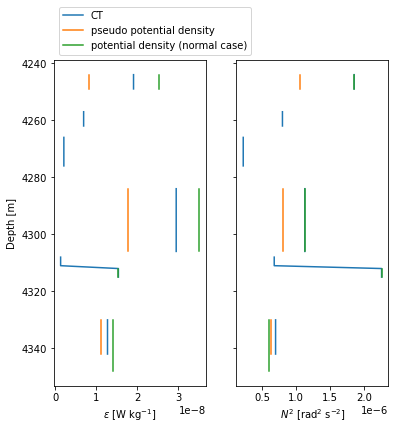

In [12]:
use_ip = False
N2_method = "teos"

eps_t, N2_t = mx.overturn.eps_overturn(
    depth, t, 35, lon, lat, use_ip=use_ip, N2_method=N2_method,
)

eps_ts, N2_ts = mx.overturn.eps_overturn(
    depth,
    t,
    SP,
    lon,
    lat,
    dnoise=2e-4,
    use_ip=use_ip,
    N2_method=N2_method,
    overturns_from_CT=True,
)

eps, N2 = mx.overturn.eps_overturn(
    depth, t, SP, lon, lat, dnoise, use_ip=use_ip, N2_method=N2_method,
)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 6))
axs[0].plot(eps_ts[cut], zc, label="CT")
axs[0].plot(eps_t[cut], zc, label="pseudo potential density")
axs[0].plot(eps[cut], zc, label="potential density (normal case)")
axs[1].plot(N2_ts[cut], zc)
axs[1].plot(N2_t[cut], zc)
axs[1].plot(N2[cut], zc)
axs[0].invert_yaxis()
axs[0].legend(loc="lower left", bbox_to_anchor=(0, 1))
axs[0].set_ylabel("Depth [m]")
axs[0].set_xlabel(r"$\epsilon$ [W kg$^{-1}$]")
axs[1].set_xlabel(r"$N^2$ [rad$^2$ s$^{-2}$]")

fig.align_labels()

The smaller noise parameter in the `overturns_from_CT` case means that more overturns are found, however, $\epsilon$ tends to be a bit lower than the normal case.